In [57]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import scipy.linalg as sp
from time import time
from tqdm import tqdm_notebook as tqdm
from numba import jit
%matplotlib inline

# 1.1)

In [3]:
def Energia(N,M):
    return (N-M)*(N+M)/(2*(N-1))

In [4]:
def sterling(X):
    if isinstance(X,(np.ndarray,list)) == True:
        x = np.zeros(len(X))
        for i in range(len(X)):
            x[i] = sterling(X[i])
        return x
    elif X == 0:
        return 0
    else:
        return X*np.log(X) - X + .5*np.log(2*np.pi*X)

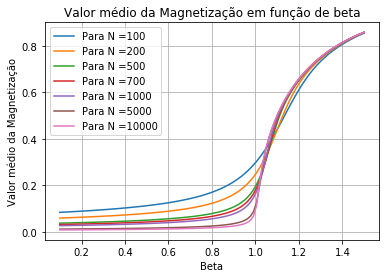

In [58]:
N = [100,200,500,700,1000,5000,10000] #Numero de particulas do sistema
for n in N:
    M = np.arange(-n , n+2, 2) # Array com todos os valores possiveis da magnetização do sistema
    beta = np.linspace(0.1,1.5,100)
    media = np.zeros(len(beta))
    E_M = Energia(n,M) # Array com todos os valores possiveis da energia do sistema
    log_omega = sterling(n) - sterling((n+M)/2) - sterling((n-M)/2) # Array com os valores possiveis do logaritmo de omega, aproximadamente
    for j in range(len(beta)):
        step = log_omega - beta[j] * E_M 
        C = max(step) # Valor máximo de ln(Omega) - beta*M
        media[j] = sum( np.abs(M)/n * np.exp(step - C))/sum(np.exp(step - C)) # Valor da media para cada valor de omega
    plt.plot(beta,media,label = 'Para N =' + str(n))
    plt.title('Valor médio da Magnetização em função de beta')
    plt.xlabel('Beta')
    plt.ylabel('Valor médio da Magnetização')
    plt.grid()
    plt.legend()
plt.show()

# 1.2.a)

In [6]:
def inversao_discreta(Populacao, array,n):
    amostra = np.zeros(n)
    new_array = np.cumsum(array)
    for j in range(n):
        i = int(len(array)/2)
        lim_min = 0
        lim_max = len(array)
        check = 0
        R = rd.random()
        if R < new_array[0]:
            amostra[j] = Populacao[0]
        if R > new_array[len(array)-1]:
            amostra[j] = Populacao[len(array)-1]
        while check != 1:
            if R > new_array[i]:
                if R < new_array[i+1]:
                    amostra[j] = Populacao[i]
                    check = 1
                else:
                    lim_min = i
                    i += int((lim_max - i)/2)
            if R < new_array[i]:
                if R > new_array[i-1]:
                    amostra[j] = Populacao[i-1]
                    check = 1
                else:
                    lim_max = i
                    i -= int((i-lim_min)/2) 
    return amostra

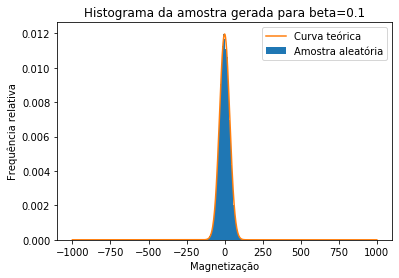

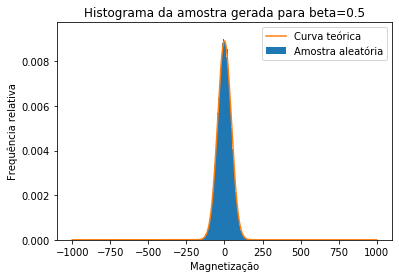

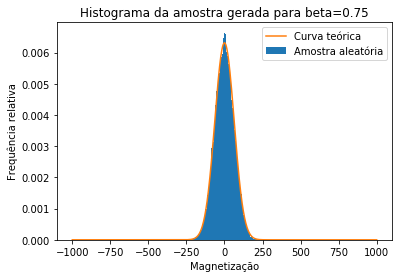

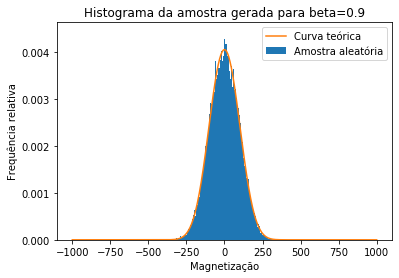

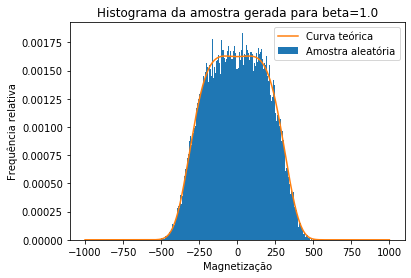

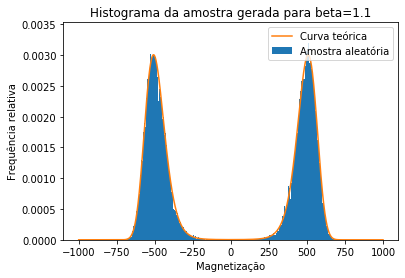

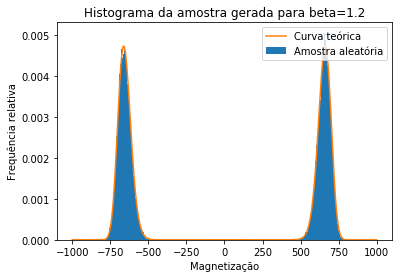

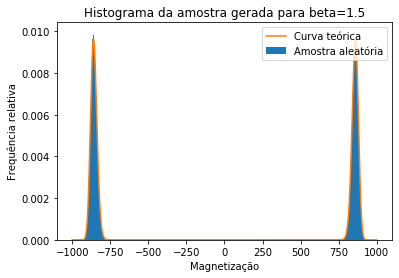

In [7]:
size_amostra = 100000
N = 1000
M = np.arange(-N , N+2, 2)
beta = [0.1,0.5,0.75,0.9,1.0,1.1,1.2,1.5]

for j in beta:
    E_M = Energia(N,M)
    log_omega = sterling(N) - sterling((N+M)/2) - sterling((N-M)/2)
    step = log_omega - (j * E_M) 
    probs = np.exp(step)/sum(np.exp(step))
    Amostra = inversao_discreta(M, probs,size_amostra)

    k = 0.5
    
    bins = int((np.max(Amostra)-np.min(Amostra))*.5)
    plt.hist(Amostra,bins, density = True , label='Amostra aleatória',align='mid')
    plt.plot(M, k * probs,label='Curva teórica')
    plt.legend(loc = 'upper right')
    plt.title('Histograma da amostra gerada para beta=' + str(j))
    plt.xlabel('Magnetização')
    plt.ylabel('Frequência relativa')
    plt.show()

# 1.2.b)

In [5]:
def corr(M,tau):
    L = len(M)-tau
    step = M[0:L] * M[tau:tau+L]
    S = np.sum(step)/L
    mediaM = np.sum(M)/len(M)
    mediaM2 = np.sum(M*M)/len(M)
    Corr = (S - (mediaM)**2)/(mediaM2-(mediaM)**2)
    return Corr

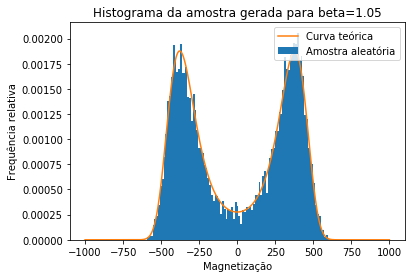

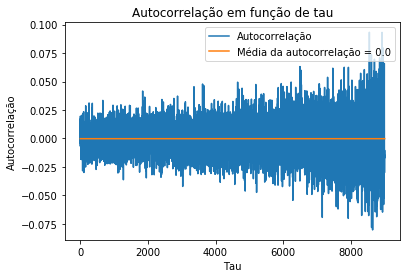

In [113]:
size_amostra = 10000
N = 1000 
beta = 1.05
M = np.arange(-N , N+2,2)

E_M = Energia(N,M)
log_omega = sterling(N) - sterling((N+M)/2) - sterling((N-M)/2)
step = log_omega - (beta * E_M) 
probs = np.exp(step)/sum(np.exp(step))
Amostra = rd.choice( M , size = size_amostra , p = probs )
k = 0.5 
    
tau = np.arange(1,size_amostra-int(size_amostra/10))
autocorr = np.zeros(len(tau))
for i in range(len(tau)):
    autocorr[i] = corr(Amostra,tau[i])
    
autocorr_media = np.zeros(len(tau)) + np.mean(autocorr)


plt.hist(Amostra, density = True , bins = 100, label='Amostra aleatória')
plt.plot(M, k * probs,label='Curva teórica' )
plt.legend(loc = 'upper right')
plt.title ( 'Histograma da amostra gerada para beta=' + str(beta) )
plt.xlabel('Magnetização')
plt.ylabel('Frequência relativa')
plt.show()

plt.plot(tau,autocorr, label='Autocorrelação')
plt.plot(tau,autocorr_media ,label='Média da autocorrelação = ' + str(round(np.mean(np.abs(autocorr)))))
plt.legend(loc = 'upper right')
plt.title ( 'Autocorrelação em função de tau' )
plt.xlabel('Tau')
plt.ylabel('Autocorrelação')
plt.show()

# 2.1.a)

In [6]:
def passeio(M_i, beta):
    p_pos_STEP = np.exp(-beta*(Energia(N,M_i+2)-Energia(N,M_i)))
    p_neg_STEP = np.exp(-beta*(Energia(N,M_i-2)-Energia(N,M_i)))
    p_pos_STEP = np.where(p_pos_STEP < 1 ,p_pos_STEP , 1 )
    p_neg_STEP = np.where(p_neg_STEP < 1 ,p_neg_STEP , 1 )
    
    p_pos = .5 * ((N-M_i)/N) * p_pos_STEP
    p_neg = .5 * ((N+M_i)/N) * p_neg_STEP
    
    r = rd.random(len(M_i))

    M_i = np.where(r < p_neg, M_i - 2 , M_i )
    M_i = np.where((r > p_neg) & (r < p_pos + p_neg) , M_i + 2 , M_i )
    
    return M_i

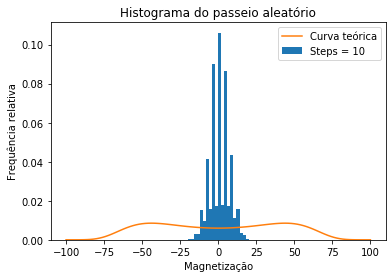

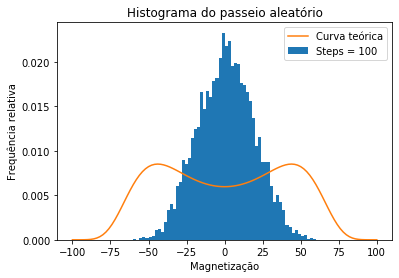

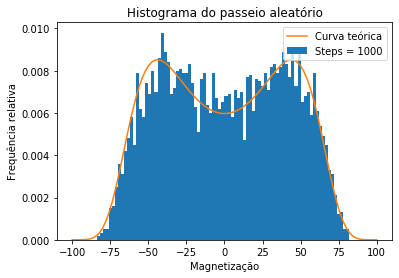

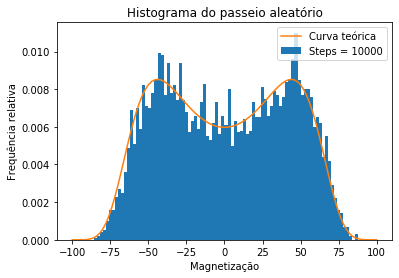

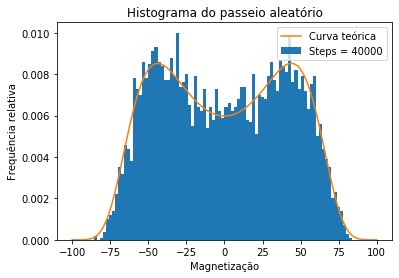

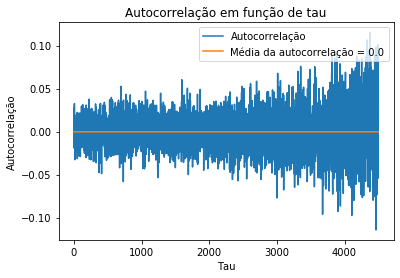

Demora 27.31893s a correr


In [137]:
t1 = time()

size_amostra = 5000
N = 100
beta = 1.05
M = np.arange(-N , N+2,2)
n_steps = [10,100,1000,10000,40000]

E_M = Energia(N,M)
log_omega = sterling(N) - sterling((N+M)/2) - sterling((N-M)/2)
step = log_omega - (beta * E_M) 
probs = np.exp(step)/sum(np.exp(step))
k = 0.5

for u in n_steps:
    Amostra = np.zeros(size_amostra)
    for i in range(u):
        Amostra = passeio(Amostra, beta)
    
    bins = int((np.max(Amostra)-np.min(Amostra))*.5)
    plt.hist(Amostra, bins , density = True,label= ('Steps = ' + str(int(u))))
    plt.plot(M, k * probs,label='Curva teórica')
    plt.legend(loc = 'upper right')
    plt.title('Histograma do passeio aleatório')
    plt.xlabel('Magnetização')
    plt.ylabel('Frequência relativa')
    plt.show()
    
tau = np.arange(1,size_amostra-int(size_amostra/10))
autocorr = np.zeros(len(tau))
for i in range(len(tau)):
    autocorr[i] = corr(Amostra,tau[i])
    
autocorr_media = np.zeros(len(tau)) + np.mean(autocorr)

plt.plot(tau,autocorr, label='Autocorrelação')
plt.plot(tau,autocorr_media ,label='Média da autocorrelação = ' + str(round(np.mean(np.abs(autocorr)))))
plt.legend(loc = 'upper right')
plt.title ( 'Autocorrelação em função de tau' )
plt.xlabel('Tau')
plt.ylabel('Autocorrelação')
plt.show()

t2 = time()
print('Demora ' + str(round(t2-t1,5)) + 's a correr')

# 3.1)

In [8]:
def Magn(amostra):
    return sum(amostra)

def Energia_ising(amostra):
    return .5 * sum(1 - amostra *(Magn(amostra) - amostra)/(N-1) )

In [9]:
def metropolis(beta,spins,T):
    mags = np.zeros(T)
    for i in range(T):
        new_spins = np.copy(spins)
        r = rd.randint(len(spins))
        new_spins[r] = new_spins[r]*(-1)
        if rd.random() < min(1, np.exp(- beta * (Energia_ising(new_spins)-Energia_ising(spins)))):
            spins = np.copy(new_spins)
        mags[i] = Magn(spins)
    return mags

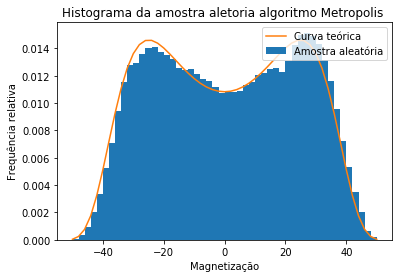

Demora 14.47629s a correr


In [160]:
# Demora aproximadamente 15s a correr

t1 = time()

N = 50 
beta = 1.05
M = np.arange(-N , N+2,2)
T = 250000
spins = rd.choice([-1,1] , N)

E_M = Energia(N,M)
log_omega = sterling(N) - sterling((N+M)/2) - sterling((N-M)/2)
step = log_omega - (beta * E_M) 
probs = np.exp(step)/sum(np.exp(step))
k = 0.5
Amostra = metropolis(beta,spins,T)

bins = int((np.max(Amostra)-np.min(Amostra))*.5)
plt.hist( Amostra , bins ,  density = True, label = 'Amostra aleatória')
plt.plot(M, k * probs,label='Curva teórica')
plt.legend(loc = 'upper right')
plt.title ( 'Histograma da amostra aletoria algoritmo Metropolis ' )
plt.xlabel('Magnetização')
plt.ylabel('Frequência relativa')
plt.show()


t2 = time()
print('Demora ' + str(round(t2-t1,5)) + 's a correr')

# 3.2)

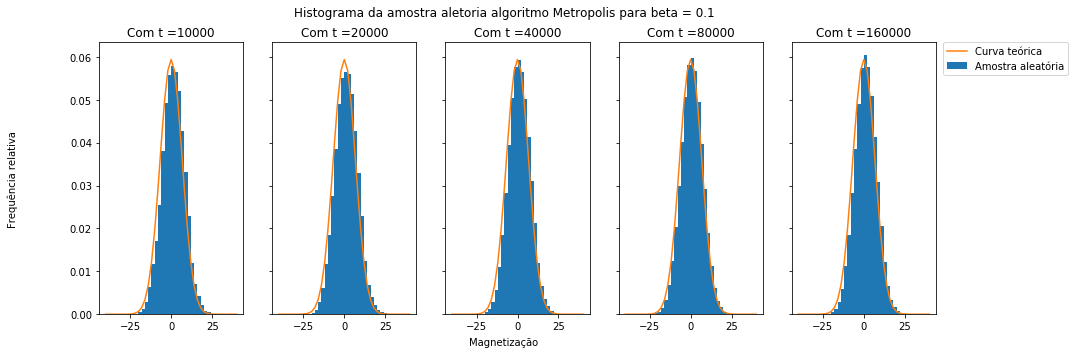

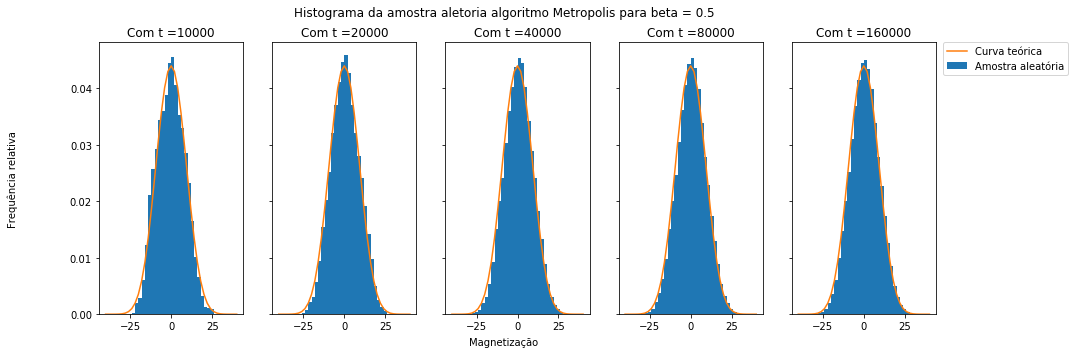

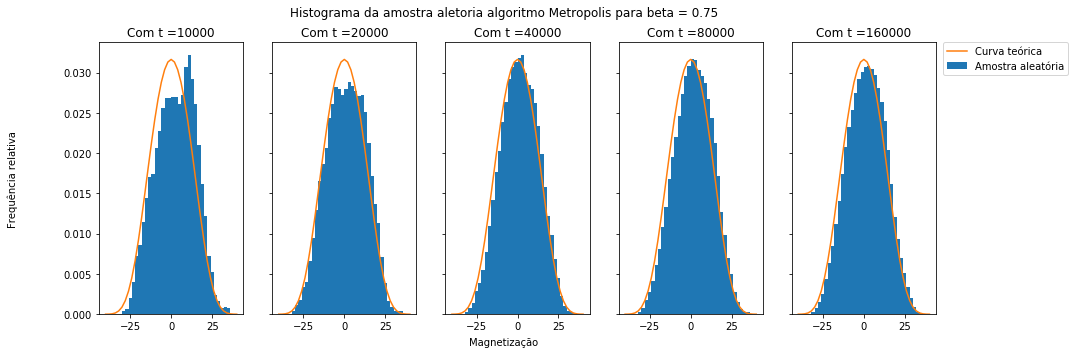

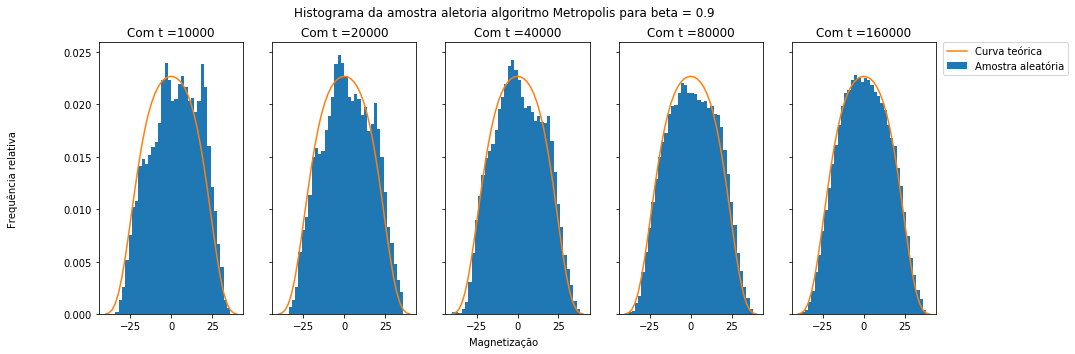

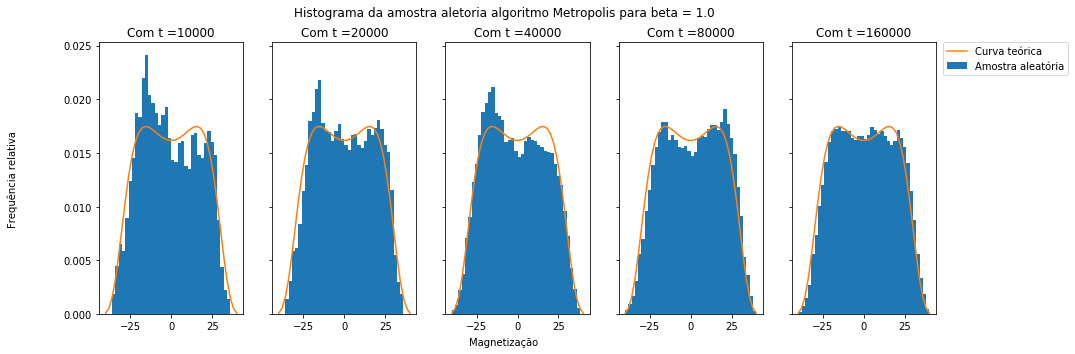

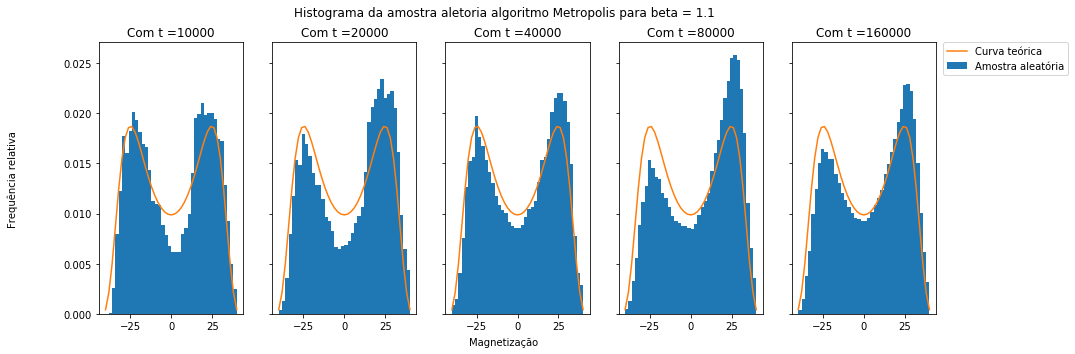

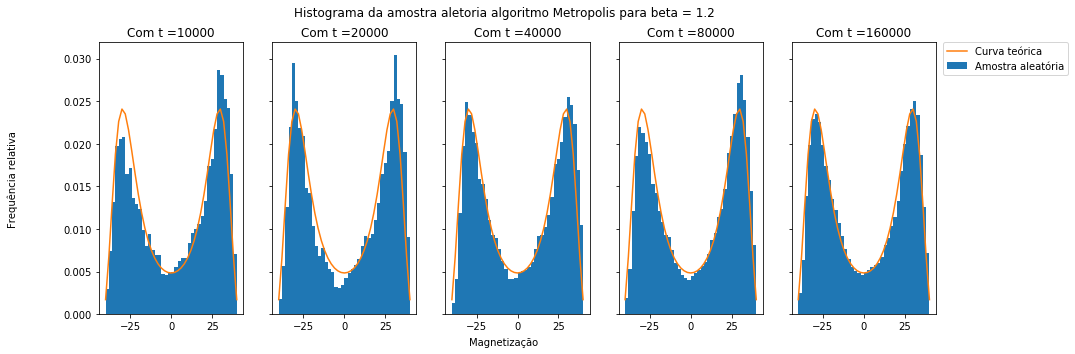

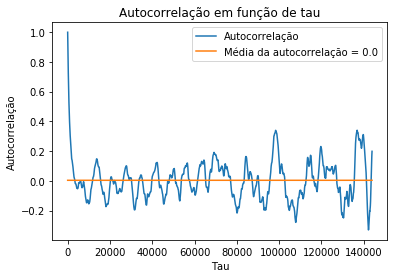

Demora 67.92965s a correr


In [162]:
# Demora aproximadamente 1min e 10 seg a correr

t1 = time()

N = 40 
BETA = [0.1,0.5,0.75,0.9,1.0,1.1,1.2]
M = np.arange(-N , N+2,2)
spins = rd.choice([-1,1] , N)
N1 = 10000
t = 2**np.arange(5) * N1


for beta in BETA:
    
    mags=metropolis(beta,spins,t[len(t)-1])
    
    E_M = Energia(N,M)
    log_omega = sterling(N) - sterling((N+M)/2) - sterling((N-M)/2)
    step = log_omega - (beta * E_M) 
    probs = np.exp(step)/sum(np.exp(step))
    k = 0.5
    
    fig, (ax1, ax2 , ax3 , ax4 ,ax5) = plt.subplots(1, 5 ,figsize=(15,5), sharey= 'all' )
    fig.suptitle('Histograma da amostra aletoria algoritmo Metropolis para beta = ' + str(beta))
    
    axes = [ax1, ax2 , ax3 , ax4 ,ax5]
    
    for c in range(len(t)):
        Amostra = mags[0:t[c]]
        bins = int((np.max(Amostra)-np.min(Amostra))*.5)
        axes[c].hist(Amostra , bins , density = True, label = 'Amostra aleatória')
        axes[c].plot(M, k * probs , label='Curva teórica')
        axes[c].set_title ( 'Com t =' + str(t[c]))
    axes[len(t)-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.text(0.5, 0.04,'Magnetização', ha='center')
    fig.text(0.04, 0.5,'Frequência relativa', va='center', rotation='vertical')

    plt.show()
        
tau = np.arange(1,len(Amostra)-int(len(Amostra)/10),100)
autocorr = np.zeros(len(tau))
for i in range(len(tau)):
    autocorr[i] = corr(Amostra,tau[i])
        
autocorr_media = np.zeros(len(tau)) + np.mean(autocorr)
    
plt.plot(tau,autocorr, label='Autocorrelação')
plt.plot(tau,autocorr_media ,label='Média da autocorrelação = ' + str(round(np.mean(np.abs(autocorr)))))
plt.legend(loc = 'upper right')
plt.title ( 'Autocorrelação em função de tau' )
plt.xlabel('Tau')
plt.ylabel('Autocorrelação')
plt.show()
    
t2 = time()
print('Demora ' + str(round(t2-t1,5)) + 's a correr')

# 3.3)

Se considerarmos o modelo de Ising a duas dimensões, a energia é calculada através da interação com os vizinhos mais proximos.

In [10]:
def Energia_HIPOTESE(N,M):
    return -M**2/(2*N)

In [11]:
def magn_ising2D(Matriz_amostral):
    return np.sum(Matriz_amostral)

In [12]:
def Energia_ising2D(Matriz_amostral):
    E = 0
    N1 = len(Matriz_amostral[:,0])
    N2 = len(Matriz_amostral[0])
    # dividindo por %Ns criamos fronteiras periodicas, e nao precisamos de nos preocupar com os extremos
    for i in range(N1):
        for j in range(N2):
            E += Matriz_amostral[i][(j+1)%N2] + Matriz_amostral[i][(j-1)%N2] + Matriz_amostral[(i+1)%N1][j] + Matriz_amostral[(i-1)%N1][j]
            E *= Matriz_amostral[i][j]
    return E

In [13]:
def deltaE_ising2D(Matriz_amostral, n1 , n2 ):
    N1 = len(Matriz_amostral[:,0])
    N2 = len(Matriz_amostral[0])
    C = Matriz_amostral[n1][(n2+1)%N2] + Matriz_amostral[n1][(n2-1)%N2] + Matriz_amostral[(n1+1)%N1][n2] + Matriz_amostral[(n1-1)%N1][n2]
    dE = 4 * C * Matriz_amostral[n1][n2]
    return dE

In [65]:
def Mags_metropolis_ising2D(beta,Matriz_amostral,T):
    mags = np.zeros(T)
    for i in range(T):
        new_spins = np.copy(Matriz_amostral)
        r1 = rd.randint(len(Matriz_amostral[:,0]))
        r2 = rd.randint(len(Matriz_amostral[0]))
        
        new_spins[r1][r2] = new_spins[r1][r2]*(-1)
        if rd.random() <.5 * min(1, np.exp(- beta * (deltaE_ising2D(new_spins,r1,r2)))):
            Matriz_amostral = np.copy(new_spins)
        mags[i] = magn_ising2D(Matriz_amostral)
    return mags

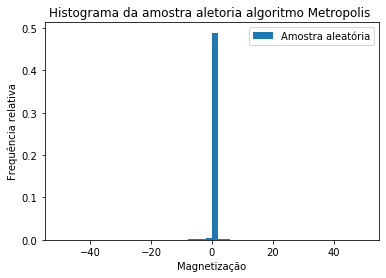

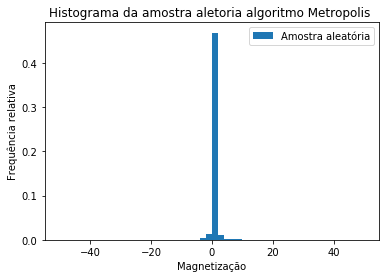

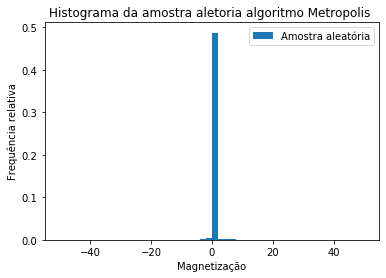

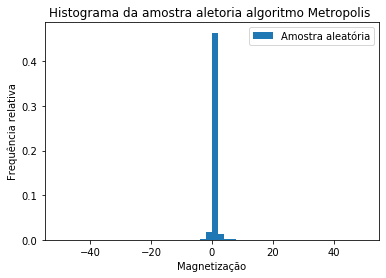

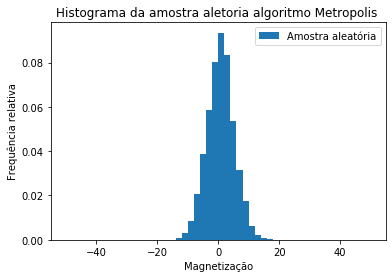

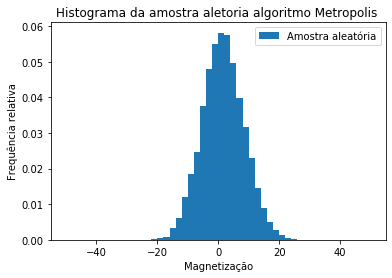

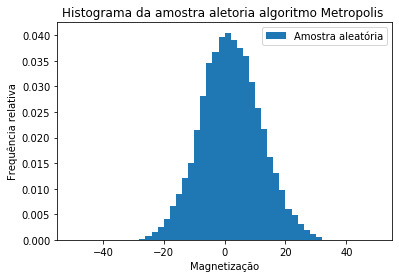

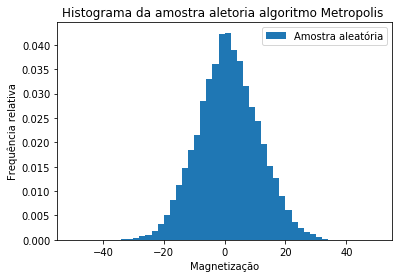


Demora 15.10969s a correr


In [79]:

BETA = [3, 2 , 1 , 0.5 , 0.2 , 0.1 ,0.01 , 0.001]
N = 10
T = 50000
for beta in tqdm(BETA):
    spins = (-1)**rd.randint(0,2,(N,N))
    
    Amostra = Mags_metropolis_ising2D(beta,spins,T)
    
    bins = int((np.max(Amostra)-np.min(Amostra))*.5)
    plt.hist( Amostra , bins = 50 ,  density = True, label = 'Amostra aleatória' , range =[-50, 50] )
    plt.legend(loc = 'upper right')
    plt.title ( 'Histograma da amostra aletoria algoritmo Metropolis com beta = ' + str(beta) )
    plt.xlabel('Magnetização')
    plt.ylabel('Frequência relativa')
    plt.show()

In [17]:
def metropolis_ising2D(beta,Matriz_amostral):
    new_spins = np.copy(Matriz_amostral)
    r1 = rd.randint(len(Matriz_amostral[:,0]))
    r2 = rd.randint(len(Matriz_amostral[0]))    
    new_spins[r1][r2] = new_spins[r1][r2]*(-1)
    if rd.random() < .5 * min(1, np.exp(- beta * (deltaE_ising2D(Matriz_amostral,r1,r2)))):
        Matriz_amostral = np.copy(new_spins)
    return Matriz_amostral

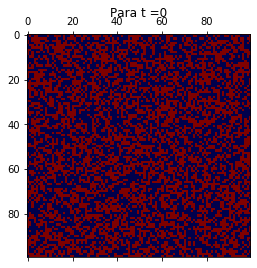

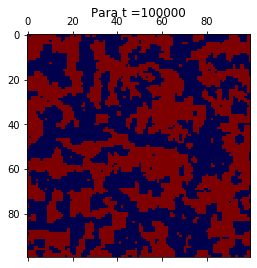

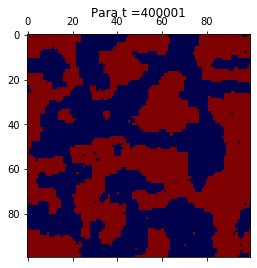

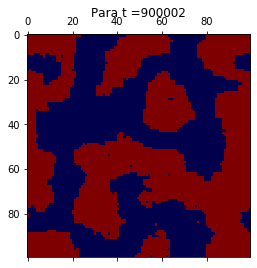

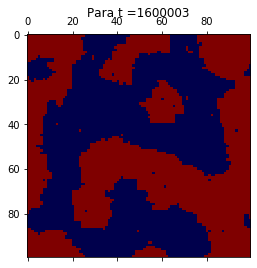

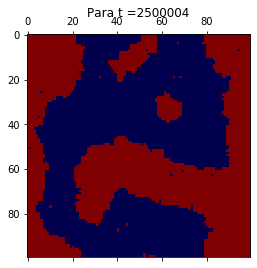

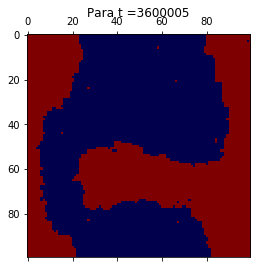

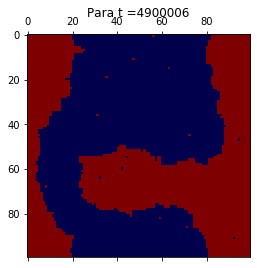

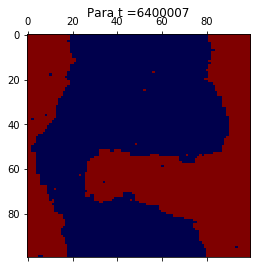

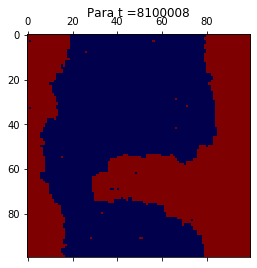

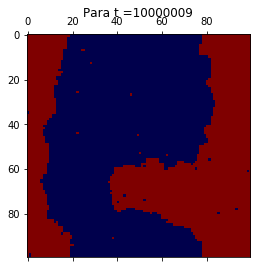

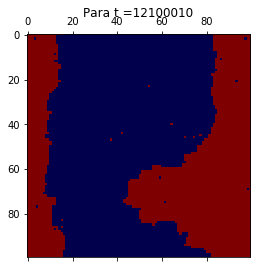

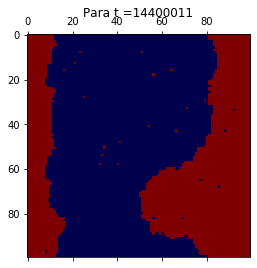

KeyboardInterrupt: 

In [71]:
N = 100
beta = 0.4
spins = (-1)**rd.randint(0,2,(N,N))
plt.matshow(spins,cmap='seismic')
plt.title('Para t =' + str(0))
plt.show()
count=0
speed=0
for i in range(50000000):
    spins = metropolis_ising2D(beta,spins)
    count+=1
    if count == round(100000*(2*speed+1))+1:
        speed += 1
        plt.matshow(spins,cmap='seismic')
        plt.title('Para t =' + str(i))
        count = 0
        plt.show()

In [19]:
BETA = [0.1,0.5,0.9,1.0,1.2]
N = 10
for beta in BETA:
    
    N_new = N**2
    M = np.arange(-N_new , N_new + 2, 2)
    E_M = Energia_HIPOTESE(N_new,M)
    log_omega = sterling(N_new) - sterling((N_new+M)/2) - sterling((N_new-M)/2)
    step = log_omega - (beta * E_M) 
    probs = np.exp(step)/sum(np.exp(step))
    k = .5
    
    axes = np.empty(4)
    spins = (-1)**rd.randint(0,2,(N,N))
    count=0
    mags = np.zeros(N**2) 
    for i in range(1,1000000001):
        spins = metropolis_ising2D(1.05,spins)
        if i%250000000 == 0 :
            axes[count] = magn_ising2D(spins)
            count += 1
    
    for c in range(len(axes)):
        bins = int((np.max(Amostra)-np.min(Amostra))*.5)
        axes[c].hist(Amostra , bins , density = True, label = 'Amostra aleatória')
        axes[c].plot(M, k * probs , label='Curva teórica')
        axes[c].set_title ( 'Com t =' + str(t[c]))
        axes[len(t)-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        fig.text(0.5, 0.04,'Magnetização', ha='center')
        fig.text(0.04, 0.5,'Frequência relativa', va='center', rotation='vertical')       

KeyboardInterrupt: 

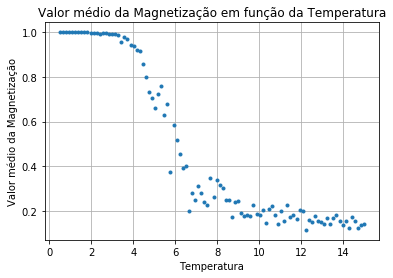

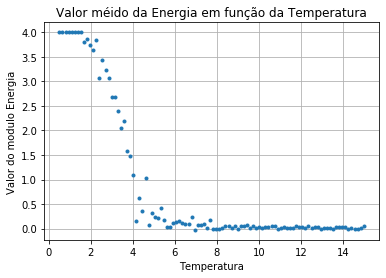

In [63]:
T = np.linspace(0.5, 15, 100)
beta = 1/T
N = 10
Magns = np.zeros(len(beta))
Ens = np.zeros(len(beta))
T = 10000
magns_step = np.zeros(T)
ens_step = np.zeros(T)
for j in tqdm(range(len(beta))):
    
    spins = np.ones((N,N)) # começar com um sistema alinhado e verificar o que acontece com o aumento da temperatura
        
    for i in range(1,T):
        spins = metropolis_ising2D(beta[j],spins)
        magns_step[i] = np.abs(magn_ising2D(spins))
        ens_step[i] = Energia_ising2D(spins)
        
    Magns[j] += np.sum(magns_step)
    Ens[j] += np.sum(ens_step)

Magns *= (1/(N**2*len(magns_step)))
Ens *= (1/(N**2*len(ens_step))) 

t = 1/beta

plt.plot(t , Magns,'.')
plt.title('Valor médio da Magnetização em função da Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Valor médio da Magnetização')
plt.grid()
#plt.legend()
plt.show()

plt.plot(t , Ens ,'.')
plt.title('Valor méido da Energia em função da Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Valor do modulo Energia')
plt.grid()
#plt.legend()
plt.show()

In [32]:
def metropolis_ising2D_2(beta,Matriz_amostral):
    for i in range(len(Matriz_amostral[:,0])):
        for i in range(len(Matriz_amostral[0])):
            new_spins = np.copy(Matriz_amostral)
            r1 = rd.randint(len(Matriz_amostral[:,0]))
            r2 = rd.randint(len(Matriz_amostral[0]))    
            new_spins[r1][r2] = new_spins[r1][r2]*(-1)
            if rd.random() < .5 * min(1, np.exp(- beta * (deltaE_ising2D(Matriz_amostral,r1,r2)))):
                Matriz_amostral = np.copy(new_spins)
    return Matriz_amostral

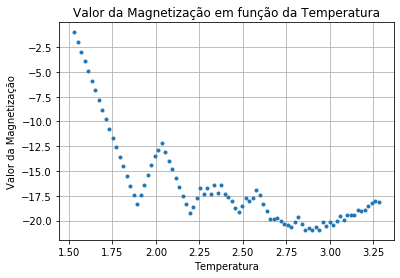

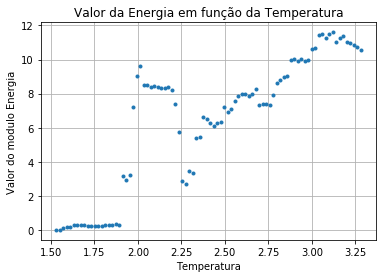

In [46]:
nt = 88
T = np.linspace(1.53, 3.28, nt)
beta = 1/T
#beta = np.linspace(0.1,1.05,100)
N = 10
Magns = np.zeros(len(beta))
Ens = np.zeros(len(beta))
for j in range(len(beta)):
    for i in range(1,1000):
        spins = mcmove(spins,beta[j])
    Magns[j:len(beta)] += magn_ising2D(spins)/(N**2)
    Ens[j:len(beta)] += Energia_ising2D(spins)/(N**2)

t = 1/beta

plt.plot(t , Magns, '.')
plt.title('Valor da Magnetização em função da Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Valor da Magnetização')
plt.grid()
#plt.legend()
plt.show()

plt.plot(t , Ens ,'.')
plt.title('Valor da Energia em função da Temperatura')
plt.xlabel('Temperatura')
plt.ylabel('Valor do modulo Energia')
plt.grid()
#plt.legend()
plt.show()

In [45]:
def initialstate(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state


def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rd.random() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.


def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag